# Neural Network with Pytorch

L'obbiettivo di questo notebook è di costruire un modello regressivo utilizzando una rete neurale. E confrontare il risultato con il modello di regressione logistica del notebook [LINK]

In un notebook precedente [LINK] abbiamo visto alcuni concetti di base di Pytorch e la costruzione di una rete neurale.

Adesso procederemo in maniera più sistematica. 

Questi sono i passi da seguire:

- preparare i dati, creare un dataset
- definire un modello, con dei parametri da "imparare"
- definire una funzione errore (o loss, o costo) 
- definire un ottimizzatore

In [170]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

## Il problema

Ho un dataset costituito da 15000 pazienti. Per ogni paziente sono registrati dei dati medici, inclusa l'età del paziente. Altri dati sono il numero di gravidanze, glucosio, pressione, etc. Infine per ogni paziente è indicato se è diabetico(1) oppure no(0).

Il problema è quello di riuscire a prevedere sulla base dei dati medici se il paziente è diabetico. 

## Load Dataset

Usiamo la classe Dataset e la customizziamo. Precisamente la classe necessita la definizione di tre funzioni:
- __init__(self)
- __len__(self)
- __getitem__(self,idx)

Nel costruttore definisco i dati del Dataset e la sua lunghezza: x, y e len.<br>
Dopodiché definisco i getter cioè come interagire con la classe, ottenendo gli elementi x,y e la lunghezza.

In [171]:
def dataProcess(lista_pazienti):
        
        MmSc = MinMaxScaler()
        StSc = StandardScaler()
        
        lista_pazienti['logAge'] = np.log10(lista_pazienti['Age'].values)

        columns_minmax = ['Pregnancies','SerumInsulin','BMI','DiabetesPedigree','logAge']
        columns_zscore = ['PlasmaGlucose','DiastolicBloodPressure','TricepsThickness']

        lista_pazienti_norm = pd.DataFrame(index=range(lista_pazienti.shape[0]))
        for column in columns_minmax:
            lista_pazienti_norm[column + '_norm'] = MmSc.fit_transform(lista_pazienti[column].values.astype(np.float64).reshape(-1, 1))
        for column in columns_zscore:
            lista_pazienti_norm[column + '_norm'] = StSc.fit_transform(lista_pazienti[column].values.astype(np.float64).reshape(-1, 1))
        
        #aggiunge colonne non mumeriche al nuovo DF
        lista_pazienti_norm[['PatientID','Diabetic']] = lista_pazienti[['PatientID','Diabetic']]
        
        return lista_pazienti_norm

In [172]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class DatiMediciDataset(Dataset):
    
    # Constructor
    def __init__(self):
        lista_pazienti = pd.read_csv('diabetes.csv')
        lista_dottori = pd.read_csv('doctors.csv', encoding = "ISO-8859-1")
        
        lista_pazienti = dataProcess(lista_pazienti)
        
        self.x = torch.from_numpy(lista_pazienti.drop(columns=['Diabetic','PatientID']).values).type(dtype=torch.float)
        self.y = torch.tensor(lista_pazienti.Diabetic.values, dtype=torch.float).view(-1,1)
        
        self.len = lista_pazienti.shape[0]
    
    # getter: get length
    def __len__(self):
        return self.len
    
    # getter: get single item
    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx,:]


Istanzio un membro di questa classe:

In [173]:
dat = DatiMediciDataset()

Adesso ho un elemento dat con le propietà x, y e len. Per esempio posso chiedermi quali sono i dati x di dat:

In [174]:
dat.x

tensor([[ 0.0000,  0.0115,  0.6690,  ...,  1.9744,  0.5239,  0.3563],
        [ 0.5714,  0.0280,  0.0804,  ..., -0.4958,  1.2996,  1.2494],
        [ 0.5000,  0.0268,  0.6161,  ...,  0.2234, -1.4453,  1.5930],
        ...,
        [ 0.0000,  0.0548,  0.0130,  ..., -0.4646,  1.0609,  0.9746],
        [ 0.0000,  0.1873,  0.0421,  ...,  0.7549,  1.5980, -0.7430],
        [ 0.2143,  0.6344,  0.4762,  ...,  0.1921, -0.3712,  1.2494]])

Partiziono il dataset in un train dataset ed un test dataset usando la funzione torch.utils.data.random_split.<br>
Uso il 80% per il training e il restante 20% per la validazione.

In [175]:
train_size = int(0.8 * dat.len)
test_size = dat.len - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dat, [train_size, test_size])

I risultato di random_split sono due subset, Ciascuno che ha come argomenti dataset (il dataset completo) e indices. Indices è una lista degli indici del sottoinsieme.<br>
Per esempio, questi sono gli indici del dataset originali che costituiscono il subset train_dataset:

In [176]:
train_dataset.indices[0:10] #visualizzo solo i primi indici

[12036, 8161, 8065, 3990, 6712, 4753, 5231, 6057, 9281, 11198]

Infine creo degli oggetti DataLoader, uno per il train_dataset e un altro per il test_dataset.<br>
Il DataLoader è molto pratico per fare un training in batch e mischiare i dati (shuffle) senza scrivere una linea di codice.  

In [177]:
trainloader      = DataLoader(dataset=train_dataset, batch_size=4000, shuffle=True)
validationloader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

## Definizione del modello

In [178]:
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F

class AZNet(Module):
    
    #Constructor
    def __init__(self):
        super(AZNet, self).__init__()
        node = 100
        self.layer1 = nn.Linear(8,node)
        self.layer2 = nn.Linear(node,node)
        self.layer3 = nn.Linear(node,1)
    
    #La funzione forward richiede un tensore x in ingresso e restituisce un tensore y in uscita
    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        y = torch.sigmoid(self.layer3(x))
        return y

Nel costruttore __init__(self) posso definire tutte la variabili che verranno usate nella funzione forward() (o eventualmente in altre funzioni). In questo caso ho la definizione dei layer che costituiscono la rete neurale.<br>
Il layer di ingresso self.layer1 è costituito da 100 nodi, ciascun nodo riceve il valore di ciascuna delle variabili di ingresso del dataset. Ciascun nodo del layer1 è connesso ai 100 nodi del layer self.layer2, questi confluiscono nel layer di uscita self.layer3 costituito da un singolo nodo.

Ogni nodo ha un bias.

Ciascun nodo ha una funzione di attivazione, una funzione fortemente non lineare, definita in forward(). In questo caso ho usato la funzione F.relu() per tutti i layer.<br>
Per come ho costruito la rete, l'uscita è una variabile float, che possiamo confrontare con la soglia 0.5 per decidere se assegnare uno 0 oppure un 1. 

Definisco un membro della classe AZNet.

In [179]:
model = AZNet()

Rivediamo come è definita la rete:

In [180]:
model

AZNet(
  (layer1): Linear(in_features=8, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=1, bias=True)
)

Di quando in quando capita di dover resettare i pesi (weight) dei layers, per esempio perché voglio rifare il training. Posso usare questi comandi per resettare i weigth e i bias

In [181]:
torch.nn.init.xavier_uniform_(model.layer1.weight)
torch.nn.init.xavier_uniform_(model.layer2.weight)
torch.nn.init.xavier_uniform_(model.layer3.weight)

Parameter containing:
tensor([[ 0.1195, -0.1350,  0.1554, -0.1193, -0.2212,  0.1751, -0.0664, -0.0128,
         -0.1324, -0.0271,  0.2334, -0.0988, -0.0994,  0.1366,  0.0868, -0.1882,
         -0.0600, -0.0529,  0.0436,  0.2385,  0.1623, -0.1477,  0.0456,  0.0493,
         -0.2337, -0.1757, -0.2381,  0.0796, -0.0932,  0.1279,  0.1993, -0.1151,
         -0.1282, -0.0136, -0.0136,  0.0741,  0.1485, -0.1511, -0.1671,  0.2047,
          0.0252,  0.1775, -0.2106,  0.0813,  0.1924, -0.0844, -0.1749, -0.1350,
         -0.2049, -0.0648,  0.0043,  0.1302, -0.0437,  0.1187,  0.0956,  0.1804,
         -0.0326, -0.1755, -0.0239, -0.0265, -0.1194,  0.0671,  0.0752,  0.0956,
         -0.1023, -0.0200,  0.0476, -0.0308,  0.0620, -0.1456,  0.1328,  0.2436,
         -0.2068,  0.1232, -0.1809, -0.1626, -0.0858,  0.1029, -0.0355, -0.0629,
         -0.1986, -0.0914, -0.1181, -0.0145, -0.2405, -0.0627,  0.0549,  0.1426,
          0.0802,  0.0610, -0.0152,  0.2256,  0.0354,  0.2362,  0.0034,  0.1627,
      

Questi sono i dati su cui effettuo il training. Per il training come detto uso il DataLoader e i dati saranno letti in batch. Al momento voglio fare verificare che il modello creato sia consistente con i dati. 

In [182]:
xtrain = dat.x[train_dataset.indices,:]
ytrain = dat.y[train_dataset.indices,:]

In [183]:
xtrain.shape

torch.Size([12000, 8])

In [184]:
ypred_train = model( xtrain )
ypred_train.shape

torch.Size([12000, 1])

Questi sono invece i dati per la validazione:

In [185]:
xvalid = dat.x[test_dataset.indices,:]
yvalid = dat.y[test_dataset.indices,:]

In [186]:
xvalid.shape

torch.Size([3000, 8])

## Definisco una funzione di errore e l'ottimizzatore

Per il tipo di classificazione, simile ad una regressione logistica, che stiamo facendo la funzione BCELoss() -Binary Cross-Entropy Loss- è la più indicata.

In [187]:
error = nn.BCELoss()

In [188]:
learning_rate = 1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [189]:
def func_accuracy(ypred, ytrue):
    ytrue = ytrue.type(dtype=torch.uint8)
    accuracy = ((ypred>0.5)==ytrue).sum().item()/ytrue.shape[0]
    return accuracy

## Training del modello

Il training consta di 101 epoch. Ad ogni epoch devo passare tutti gli elementi del train dataset. Ad ogni ciclo del loop un batch viene processato.<br>

Per ogni ciclo:
- l'uscita del modello viene calcolata
- calcolo l'errore tra ypred e ytrue: criterion(ypred, ytrue)
- calcolo il gradiente con la funzione backward()
- aggiorno i parametri dell'ottimizzazione: optimizer step()
- azzero il gradiente

inoltre:
- calcolo l'accuratezza della previsione
- memorizzo i risultati dell'errore e dell'accuratezza
- calcolo l'errore e l'accuratezza del dataset di validazione

In [190]:
%%time
LOSS = []
ACC = []
LOSS_VALID = []
ACC_VALID = []
i = 0

for epoch in range(1000):
    for xtrain,ytrain in trainloader:
        ypred_train = model( xtrain ) #calcolo l'uscita
        loss = error(ypred_train, ytrain)         #calcolo l'errore
        loss.backward()        #calcolo del gradiente
        optimizer.step()       #aggiornamento ei parametri
        optimizer.zero_grad()  #azzeramento del gradiente
        accuracy = func_accuracy(ypred_train, ytrain) #calcolo l'accuratezza
        if np.mod(i,100)==0:
            print("Iterazione nr: %i - Valore della funzione di loss: %2.4f - Accuratezza: %2.2f" %(i,loss.item(), accuracy))
        LOSS.append(loss.item()) #memorizzo in una lista. uso item() per avere solo lo scalare invece del tensore
        ACC.append(accuracy) #

        #validazione
        ypred_valid = model(xvalid)
        loss_valid = error(ypred_valid,yvalid)
        accuracy_valid = func_accuracy(ypred_valid,yvalid)
        LOSS_VALID.append(loss_valid.item())
        ACC_VALID.append(accuracy_valid)
        
        i += 1

Iterazione nr: 0 - Valore della funzione di loss: 0.6705 - Accuratezza: 0.67
Iterazione nr: 100 - Valore della funzione di loss: 0.6214 - Accuratezza: 0.66
Iterazione nr: 200 - Valore della funzione di loss: 0.5553 - Accuratezza: 0.70
Iterazione nr: 300 - Valore della funzione di loss: 0.4957 - Accuratezza: 0.75
Iterazione nr: 400 - Valore della funzione di loss: 0.4953 - Accuratezza: 0.76
Iterazione nr: 500 - Valore della funzione di loss: 0.4512 - Accuratezza: 0.78
Iterazione nr: 600 - Valore della funzione di loss: 0.4331 - Accuratezza: 0.79
Iterazione nr: 700 - Valore della funzione di loss: 0.4357 - Accuratezza: 0.79
Iterazione nr: 800 - Valore della funzione di loss: 0.4478 - Accuratezza: 0.78
Iterazione nr: 900 - Valore della funzione di loss: 0.4218 - Accuratezza: 0.80
Iterazione nr: 1000 - Valore della funzione di loss: 0.4259 - Accuratezza: 0.79
Iterazione nr: 1100 - Valore della funzione di loss: 0.4289 - Accuratezza: 0.80
Iterazione nr: 1200 - Valore della funzione di loss:

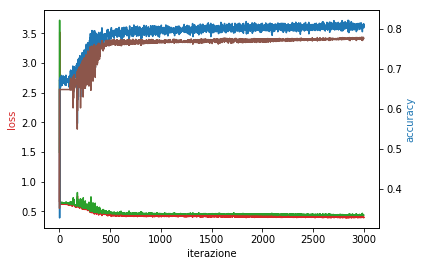

In [191]:
fig1, ax1 = plt.subplots()
color = 'tab:red'
color2 = 'tab:green'

ax1.set_xlabel('iterazione')
ax1.set_ylabel('loss', color=color)
ax1.plot(range(len(LOSS)),LOSS,color=color)
ax1.plot(range(len(LOSS_VALID)),LOSS_VALID,color=color2)

ax2 = ax1.twinx()

color = 'tab:blue'
color2 = 'tab:brown'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(range(len(ACC)),ACC,color=color)
ax2.plot(range(len(ACC_VALID)),ACC_VALID,color=color2)

plt.show()

## Qualità del modello

Come misura della qualità del modello uso la curva ROC. Genero una curva per il dataset di training e una per quello di validazione (test).

Inizio con il definire i dati sui quali calcolare la qualità del modello. Per il dataset di training calcolo la curva sull'intero dataset. Così pure sul dataset di test.

Per vedere quali dati fanno parte del dataset di training uso <strong>train_dataset.indices</strong>

In [192]:
xtrain = dat.x[train_dataset.indices,:]
ytrain = dat.y[train_dataset.indices,:]

Calcoliamo l'uscita del modello come model(dati-in-input)

In [193]:
ypred_train = model(xtrain)

L'uscita del modello è un tensore il cui valore scalare è compreso tra 0 e 1 (funzione sigmoid in uscita). Questo scalare può essere interpretato come la probabilità che la classe di uscita sia 1. 

Se voglio interpretare l'uscita in maniera binaria devo confrontare l'uscita con la soglia (0.5). Nel caso in cui sia superiore alla soglia la classe predetta è 1. In caso contrario la classe è 0.

In [194]:
ypred_train_bin = (ypred_train.detach()>0.5).numpy()

Analogamente per i dati della validazione usiamo test_dataset.indices:

In [195]:
xvalid = test_dataset.dataset.x[test_dataset.indices,:]
yvalid = test_dataset.dataset.y[test_dataset.indices,:]

Calcoliamo l'uscita del modello con i dati di validazione come ingresso

In [196]:
ypred_valid = model(xvalid)
ypred_valid_bin = (ypred_valid.detach()>0.5).numpy()

Importo la funzione <strong>roc_curve()</strong>.

In [197]:
from sklearn.metrics import roc_curve

La funzione roc_curve() accetta come argomenti sia numpy array che tensori. Se diamo un tensore come input dobbiamo usare il metodo detach(), in quanto il tensore deve avere l'etichetta requires_grad=False.<br>
ypred_train di default ha requires_grad=True

In [198]:
fpr_train, tpr_train, _ = roc_curve(ytrain,ypred_train.detach())
fpr_test, tpr_test, _   = roc_curve(yvalid,ypred_valid.detach())

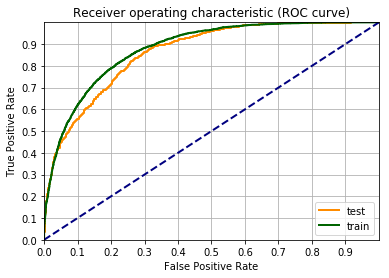

In [199]:
fgr1 = plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange', label="test", lw=lw)
plt.plot(fpr_train, tpr_train, color='darkgreen', label="train", lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.0])
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.grid(which='both')
plt.show()

Un'altra metrica è la <strong>confusion matrix</strong>, che si può vedere nella figura sottostante.<br>
Come si vede ho due assi, valore vero e valore predetto.<br>
Ogni esempio del dataset può essere inserito in una delle quattro classi:

- true positive (tp): il valore vero è 1 e il valore predetto è 1
- false positive (fp): il valore vero è 0 ma il valore predetto è 1
- true negative (tn): il valore vero è 0 e il valore predetto è 0
- false negative (fn): il valore vero è 1 ma il valore predetto è 0

Come si intuisce due delle classi sono correttamente classificate (true positive e true negative), mentre le altre due sono classificate erroneamente.

![title](https://www.1week4.com/wp-content/uploads/2019/07/logistic-regression1-e1562588720843.png)

Calcolo la matrice di confusione usando la funzione <strong>confusion_matrix()</strong> di sklearn

In [200]:
from sklearn.metrics import confusion_matrix

In [201]:
tn, fp, fn, tp = confusion_matrix(ytrain, ypred_train_bin ).ravel()
tn, fp, fn, tp

(7125, 929, 1370, 2576)

Infine posso usare questi valori per calcolare Accuratezza, precisione, recall e valore F1.

\begin{equation}
Accuratezza: \quad A = \frac{\text{nr. di esempi correttamente classificati}}{\text{nr. totale di esempi}} = \frac{tp+tn}{tp+tn+fn+fp}
\end{equation}

\begin{equation}
Precisione: \quad P = \frac{\text{nr. di true positive}}{\text{nr. di predizioni positive}} = \frac{tp}{tp+fp}
\end{equation}

\begin{equation}
Recall: \quad R = \frac{\text{nr. di true positive}}{\text{nr. veri positivi}} = \frac{tp}{tp+fn}
\end{equation}

\begin{equation}
F_1 score: \quad F_1 = 2 \frac{P\cdot R}{P+R}
\end{equation}

In [202]:
A = (tp+tn)/(tp+tn+fn+fp)
P = tp/(tp+fp)
R = tp/(tp+fn)
F1 = 2*(P*R)/(P+R)
print('L\'accuratezza è %0.1f%%' %(A*100))
print('La precisione è %0.1f%%' %(P*100))
print('Il recall è %0.1f%%' %(R*100))
print('Il punteggio F1 è %0.1f%%' %(F1*100))

L'accuratezza è 80.8%
La precisione è 73.5%
Il recall è 65.3%
Il punteggio F1 è 69.1%


## Training on CUDA

L'ultima cosa che voglio vedere in questo post è come fare il training usando la GPU.

Innanzitutto vediamo se c'è un dispositivo CUDA disponibile.

In [203]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


Il modello è lo stesso del caso precedente.

In [204]:
class AZNet2(Module):
    
    #Constructor
    def __init__(self):
        super(AZNet2, self).__init__()
        node = 100
        self.layer1 = nn.Linear(8,node)
        self.layer2 = nn.Linear(node,node)
        self.layer3 = nn.Linear(node,1)
    
    #La funzione forward richiede un tensore x in ingresso e restituisce un tensore y in uscita
    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        y = torch.sigmoid(self.layer3(x))
        return y

Instanziamo un membro di questa classe:

In [205]:
cuda_model = AZNet2()

Resettiamo i pesi del modello (utile solo nel caso in cui è un secondo training):

In [206]:
torch.nn.init.xavier_uniform_(cuda_model.layer1.weight)
torch.nn.init.xavier_uniform_(cuda_model.layer2.weight)
torch.nn.init.xavier_uniform_(cuda_model.layer3.weight)

Parameter containing:
tensor([[-0.1593,  0.2208,  0.0162, -0.0854,  0.0086, -0.1862, -0.0402, -0.2027,
         -0.1645, -0.0944, -0.0943, -0.0090, -0.0008, -0.1584,  0.1360,  0.0070,
          0.2302, -0.0985, -0.0456,  0.0205, -0.2079,  0.1289,  0.2026,  0.2421,
          0.1877, -0.1899,  0.1783,  0.0349, -0.1904, -0.1317,  0.0422, -0.1449,
         -0.0451,  0.0010, -0.0056, -0.0185, -0.0414,  0.0844, -0.0948,  0.1731,
         -0.1687, -0.0096,  0.0799,  0.0753,  0.0915, -0.0025, -0.0267,  0.0615,
          0.1800,  0.0630, -0.0841,  0.0707, -0.1323,  0.2333, -0.0580, -0.0544,
          0.0439, -0.1477, -0.0178, -0.0434, -0.1266,  0.0186,  0.1464, -0.2288,
          0.1166,  0.1368, -0.0975, -0.2384, -0.1546, -0.1055, -0.0562, -0.0663,
          0.0706, -0.2216, -0.0501,  0.0839,  0.0855,  0.1435,  0.1647,  0.0225,
         -0.0305, -0.2213,  0.1150, -0.0058, -0.1140, -0.1727,  0.1174,  0.0179,
          0.2331, -0.1048,  0.1922,  0.0639, -0.1833, -0.2329, -0.0708, -0.1361,
      

Per il modello di rete definiamo che verrà fatto il training sul nostro dispositivo cuda

In [207]:
cuda_model.cuda()

AZNet2(
  (layer1): Linear(in_features=8, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=1, bias=True)
)

In [208]:
dtype_ = torch.cuda.FloatTensor

In [209]:
xtrain_cuda = xtrain.type(dtype_)

In [210]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(cuda_model.parameters(),lr=1)

In [211]:
%%time
LOSS = []
ACC = []
LOSS_VALID = []
ACC_VALID = []
i = 0

for epoch in range(1000): #epoch
    for xtrain,ytrain in trainloader: #ad ogni ciclo, un batch di 4000 samples viene processato
        xtrain = xtrain.type(dtype_)
        ytrain = ytrain.type(dtype_)
        ypred_train = cuda_model( xtrain )        #calcolo l'uscita
        loss = error(ypred_train, ytrain)         #calcolo l'errore
        loss.backward()        #calcolo del gradiente
        optimizer.step()       #aggiornamento ei parametri
        optimizer.zero_grad()  #azzeramento del gradiente
        accuracy = func_accuracy(ypred_train, ytrain) #calcolo l'accuratezza
        if np.mod(i,100)==0:
            print("Iterazione nr: %i - Valore della funzione di loss: %2.4f - Accuratezza: %2.2f" %(i,loss.item(), accuracy))
        LOSS.append(loss.item()) #memorizzo in una lista. uso item() per avere solo lo scalare invece del tensore
        ACC.append(accuracy) #

        #validazione
        xvalid = xvalid.type(dtype_)
        yvalid = yvalid.type(dtype_)
        ypred_valid = cuda_model(xvalid)
        loss_valid = error(ypred_valid,yvalid)
        accuracy_valid = func_accuracy(ypred_valid,yvalid)
        LOSS_VALID.append(loss_valid.item())
        ACC_VALID.append(accuracy_valid)
        
        i += 1

Iterazione nr: 0 - Valore della funzione di loss: 0.6338 - Accuratezza: 0.67
Iterazione nr: 100 - Valore della funzione di loss: 0.6686 - Accuratezza: 0.59
Iterazione nr: 200 - Valore della funzione di loss: 0.6012 - Accuratezza: 0.68
Iterazione nr: 300 - Valore della funzione di loss: 0.5626 - Accuratezza: 0.71
Iterazione nr: 400 - Valore della funzione di loss: 0.5156 - Accuratezza: 0.75
Iterazione nr: 500 - Valore della funzione di loss: 0.4309 - Accuratezza: 0.80
Iterazione nr: 600 - Valore della funzione di loss: 0.4356 - Accuratezza: 0.79
Iterazione nr: 700 - Valore della funzione di loss: 0.4331 - Accuratezza: 0.79
Iterazione nr: 800 - Valore della funzione di loss: 0.4294 - Accuratezza: 0.79
Iterazione nr: 900 - Valore della funzione di loss: 0.4236 - Accuratezza: 0.80
Iterazione nr: 1000 - Valore della funzione di loss: 0.4244 - Accuratezza: 0.79
Iterazione nr: 1100 - Valore della funzione di loss: 0.4283 - Accuratezza: 0.80
Iterazione nr: 1200 - Valore della funzione di loss:

In [212]:
def generateNonLinearFeatures(x,max_exp):
#given a marix with features in column, generate a new matrix with all the polynomial combination up to max_exp

    import itertools

    terms = []
    num_feat = x.shape[1]
    
    #il prossimo comando genera una lista delle possibili combinazioni delle variabili fino al max_exp
    #Esempio: num_Feat=2 max_exp=2 genera:
    #[(0, 0),  (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)] corrispondenti a:
    # x^0 x^0  x^0 x^1 x^0 x^2 x^1 x^1 x^1 x^2 x^2 x^2
    terms = list(itertools.combinations_with_replacement(list(range(num_feat+1)), max_exp))
    
#     for a in itertools.combinations_with_replacement(list(range(num_feat+1)), max_exp): #OLD
#         terms.append(a)


    if 'pol' in locals(): #rimuove la variabile pol se esiste già
        del pol

    for i in range(len(terms)): 
        polcol = np.ones(x.shape[0]).reshape(x.shape[0],1)
        sum=0
        for j in range(max_exp):
#             print(i,j) #for debug only
            sum=sum+int(terms[i][j])
            if terms[i][j]!=0:
                polcol = np.multiply(polcol,x[:,int(terms[i][j])-1].reshape(x.shape[0],1))
        if (sum!=0): #exclude case all zeros (0,0), don't add the column
            if 'pol' in locals():
                pol = np.column_stack([pol, polcol])
            else:
                pol = polcol

    return pol

In [213]:
def dataProcess_nonLinear(lista_pazienti, max_grad):
        
        MmSc = MinMaxScaler()
        StSc = StandardScaler()
        
        lista_pazienti['logAge'] = np.log10(lista_pazienti['Age'].values)

        columns_minmax = ['Pregnancies','SerumInsulin','BMI','DiabetesPedigree','logAge']
        columns_zscore = ['PlasmaGlucose','DiastolicBloodPressure','TricepsThickness']

        lista_pazienti_norm = pd.DataFrame(index=range(lista_pazienti.shape[0]))
        for column in columns_minmax:
            lista_pazienti_norm[column + '_norm'] = MmSc.fit_transform(lista_pazienti[column].values.astype(np.float64).reshape(-1, 1))
        for column in columns_zscore:
            lista_pazienti_norm[column + '_norm'] = StSc.fit_transform(lista_pazienti[column].values.astype(np.float64).reshape(-1, 1))
        
        lista_pazient_norm = generateNonLinearFeatures(lista_pazienti_norm.values, max_grad)
        
        #aggiunge colonne non mumeriche al nuovo DF
        lista_pazienti_norm[['PatientID','Diabetic']] = lista_pazienti[['PatientID','Diabetic']]
        
        return lista_pazienti_norm

In [214]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class DatiMediciDataset(Dataset):
    
    # Constructor
    def __init__(self, max_grad):
        lista_pazienti = pd.read_csv('diabetes.csv')
        lista_dottori = pd.read_csv('doctors.csv', encoding = "ISO-8859-1")
        
        lista_pazienti = dataProcess(lista_pazienti) #normalizzazione delle feature numeriche [DATAFRAME]
        
        lista_pazienti_array = lista_pazienti.drop(columns=['Diabetic','PatientID']).values
        
        lista_pazienti_nonlinear_array = generateNonLinearFeatures(lista_pazienti_array, max_grad)
        
        self.x = torch.from_numpy(lista_pazienti_nonlinear_array).type(dtype=torch.float)
        self.y = torch.tensor(lista_pazienti.Diabetic.values, dtype=torch.float).view(-1,1)
        
        self.len = lista_pazienti.shape[0]
    
    # getter: get length
    def __len__(self):
        return self.len
    
    # getter: get single item
    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx,:]


In [215]:
dat = DatiMediciDataset(3)

In [216]:
dat.x.shape

torch.Size([15000, 164])

In [217]:
train_size = int(0.8 * dat.len)
test_size = dat.len - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dat, [train_size, test_size])

In [218]:
trainloader      = DataLoader(dataset=train_dataset, batch_size=4000, shuffle=True)
validationloader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

In [219]:
class AZNet(Module):
    
    #Constructor
    def __init__(self):
        super(AZNet, self).__init__()
        node = 200
        self.layer1 = nn.Linear( dat.x.shape[1] ,node)
        self.layer2 = nn.Linear(node,node)
        self.layer3 = nn.Linear(node,node)
        self.layer4 = nn.Linear(node,1)
    
    #La funzione forward richiede un tensore x in ingresso e restituisce un tensore y in uscita
    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        y = torch.sigmoid(self.layer4(x))
        return y

In [220]:
model = AZNet()

In [221]:
model

AZNet(
  (layer1): Linear(in_features=164, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=200, bias=True)
  (layer3): Linear(in_features=200, out_features=200, bias=True)
  (layer4): Linear(in_features=200, out_features=1, bias=True)
)

Resetto weight e bias della rete:

In [222]:
torch.nn.init.xavier_uniform_(model.layer1.weight)
torch.nn.init.xavier_uniform_(model.layer2.weight)
torch.nn.init.xavier_uniform_(model.layer3.weight)
torch.nn.init.xavier_uniform_(model.layer4.weight)

Parameter containing:
tensor([[-0.0826, -0.1452, -0.1381,  0.0581,  0.1371, -0.1672,  0.0436,  0.0211,
          0.0714, -0.1001,  0.0701,  0.0162, -0.0131,  0.1717, -0.1633,  0.0949,
         -0.0624,  0.0292,  0.0740, -0.0961, -0.0274,  0.0006,  0.1191,  0.1650,
          0.0987, -0.1251,  0.0436,  0.1217,  0.0697, -0.1567, -0.0471, -0.0693,
         -0.0183,  0.1297,  0.0197,  0.0457,  0.1044, -0.0308,  0.1152, -0.0340,
          0.1497,  0.1583, -0.0795, -0.0594,  0.0070, -0.1128,  0.0532,  0.0658,
         -0.1366, -0.1651,  0.0590,  0.1590, -0.0585,  0.0591, -0.0910, -0.0154,
          0.1451, -0.0866, -0.0851,  0.1518, -0.0089, -0.0347, -0.0747, -0.0144,
          0.1459,  0.0793,  0.1511,  0.0264, -0.0262,  0.0107, -0.1619, -0.1715,
         -0.0170,  0.0111,  0.1670, -0.0844, -0.1239, -0.0322,  0.0510,  0.0436,
         -0.1215, -0.0035,  0.0658,  0.0558,  0.1529, -0.0996,  0.0620,  0.1067,
          0.0675, -0.1259, -0.1603, -0.0693, -0.0018,  0.0235,  0.0012,  0.0881,
      

In [223]:
xtrain = dat.x[train_dataset.indices,:]
ytrain = dat.y[train_dataset.indices,:]

In [224]:
ypred_train = model( xtrain )
ypred_train.shape

torch.Size([12000, 1])

In [225]:
xvalid = dat.x[test_dataset.indices,:]
yvalid = dat.y[test_dataset.indices,:]

In [226]:
error = nn.BCELoss()

In [227]:
learning_rate = 1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [228]:
%%time
LOSS = []
ACC = []
LOSS_VALID = []
ACC_VALID = []
i = 0

for epoch in range(1000):
    for xtrain,ytrain in trainloader:
        ypred_train = model( xtrain ) #calcolo l'uscita
        loss = error(ypred_train, ytrain)         #calcolo l'errore
        loss.backward()        #calcolo del gradiente
        optimizer.step()       #aggiornamento ei parametri
        optimizer.zero_grad()  #azzeramento del gradiente
        accuracy = func_accuracy(ypred_train, ytrain) #calcolo l'accuratezza
        if np.mod(i,100)==0:
            print("Iterazione nr: %i - Valore della funzione di loss: %2.4f - Accuratezza: %2.2f" %(i,loss.item(), accuracy))
        LOSS.append(loss.item()) #memorizzo in una lista. uso item() per avere solo lo scalare invece del tensore
        ACC.append(accuracy) #

        #validazione
        ypred_valid = model(xvalid)
        loss_valid = error(ypred_valid,yvalid)
        accuracy_valid = func_accuracy(ypred_valid,yvalid)
        LOSS_VALID.append(loss_valid.item())
        ACC_VALID.append(accuracy_valid)
        
        i += 1

Iterazione nr: 0 - Valore della funzione di loss: 0.7290 - Accuratezza: 0.33
Iterazione nr: 100 - Valore della funzione di loss: 0.6281 - Accuratezza: 0.67
Iterazione nr: 200 - Valore della funzione di loss: 0.6035 - Accuratezza: 0.67
Iterazione nr: 300 - Valore della funzione di loss: 0.5580 - Accuratezza: 0.70
Iterazione nr: 400 - Valore della funzione di loss: 0.5506 - Accuratezza: 0.72
Iterazione nr: 500 - Valore della funzione di loss: 0.4083 - Accuratezza: 0.81
Iterazione nr: 600 - Valore della funzione di loss: 0.4071 - Accuratezza: 0.81
Iterazione nr: 700 - Valore della funzione di loss: 0.4101 - Accuratezza: 0.81
Iterazione nr: 800 - Valore della funzione di loss: 0.3780 - Accuratezza: 0.82
Iterazione nr: 900 - Valore della funzione di loss: 0.3758 - Accuratezza: 0.82
Iterazione nr: 1000 - Valore della funzione di loss: 0.4266 - Accuratezza: 0.79
Iterazione nr: 1100 - Valore della funzione di loss: 0.3762 - Accuratezza: 0.83
Iterazione nr: 1200 - Valore della funzione di loss:

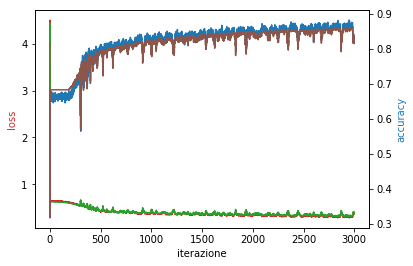

In [229]:
fig1, ax1 = plt.subplots()
color = 'tab:red'
color2 = 'tab:green'

ax1.set_xlabel('iterazione')
ax1.set_ylabel('loss', color=color)
ax1.plot(range(len(LOSS)),LOSS,color=color)
ax1.plot(range(len(LOSS_VALID)),LOSS_VALID,color=color2)

ax2 = ax1.twinx()

color = 'tab:blue'
color2 = 'tab:brown'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(range(len(ACC)),ACC,color=color)
ax2.plot(range(len(ACC_VALID)),ACC_VALID,color=color2)

plt.show()

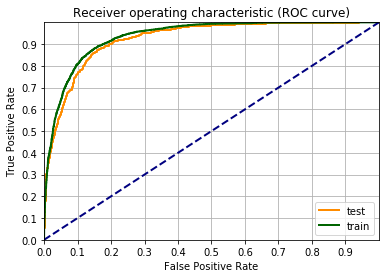

L'accuratezza è 83.5%
La precisione è 69.0%
Il recall è 92.7%
Il punteggio F1 è 79.1%


In [230]:
xtrain = dat.x[train_dataset.indices,:]
ytrain = dat.y[train_dataset.indices,:]

ypred_train = model(xtrain)

ypred_train_bin = (ypred_train.detach()>0.5).numpy()

xvalid = test_dataset.dataset.x[test_dataset.indices,:]
yvalid = test_dataset.dataset.y[test_dataset.indices,:]

ypred_valid = model(xvalid)
ypred_valid_bin = (ypred_valid.detach()>0.5).numpy()

fpr_train, tpr_train, _ = roc_curve(ytrain,ypred_train.detach())
fpr_test, tpr_test, _   = roc_curve(yvalid,ypred_valid.detach())

fgr1 = plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange', label="test", lw=lw)
plt.plot(fpr_train, tpr_train, color='darkgreen', label="train", lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.0])
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.grid(which='both')
plt.show()

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(ytrain, ypred_train_bin ).ravel()
tn, fp, fn, tp

A = (tp+tn)/(tp+tn+fn+fp)
P = tp/(tp+fp)
R = tp/(tp+fn)
F1 = 2*(P*R)/(P+R)
print('L\'accuratezza è %0.1f%%' %(A*100))
print('La precisione è %0.1f%%' %(P*100))
print('Il recall è %0.1f%%' %(R*100))
print('Il punteggio F1 è %0.1f%%' %(F1*100))